In [1]:
pwd

'/data2/mito_lineage/Analysis/multiplex'

In [2]:
AD_F = "../data/mitoDNA/cellSNP.tag.AD.mtx"
DP_F = "../data/mitoDNA/cellSNP.tag.DP.mtx"

In [3]:
# Parameters
AD_F = "data/jan21_2021/chrM/P2_cellSNP_minC200_minAF0.01/cellSNP.tag.AD.mtx"
DP_F = "data/jan21_2021/chrM/P2_cellSNP_minC200_minAF0.01/cellSNP.tag.DP.mtx"


In [4]:
pwd

'/data2/mito_lineage/Analysis/multiplex'

# Using vireo for clonal reconstruction - mitochondrial mutations

The mitochondrial mutations data set is extracted from [Ludwig et al, Cell, 2019](https://doi.org/10.1016/j.cell.2019.01.022), the 9 variants used here are from Supp Fig. 2F (and main Fig. 2F).

For clonal reconstruction, we are using the core class `vireoSNP.Vireo` with multiple initializations

In [5]:
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt

print(vireoSNP.__version__)

0.4.2


In [6]:
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

In [7]:
AD = mmread(AD_F).tocsc()
DP = mmread(DP_F).tocsc()

In [8]:
AD_shape = AD.todense().shape

## New implementation in v0.3.0

In [9]:
from vireoSNP import Vireo

Note, there are a few key parameters:

* `n_donor`: it means number of clones here, but you need to determine yourself. You can choose the one with highest ELBO (see next section)
* `n_GT`: number of different genotype. For somatic mutations, we could assume that there are only two, namely present or absent
* `is_theta_ASE`: whether allelic ratio is variant specific. For mitochondrial mutations, we choose True as allelic ratio can different from variant to variant

### Multiple initialization is needed to avoid local optima

In [10]:
np.random.seed(1)

n_initials = 50
_models_all = []
for i in range(n_initials):
    _modelCA = Vireo(n_var=AD_shape[0], n_cell=AD_shape[1], n_donor=3, n_GT=2,
                     fix_beta_sum=False, ASE_mode=True)
    _modelCA.set_prior(beta_mu_prior=np.array([[0.01, 0.5]]))
    _modelCA.fit(AD, DP, min_iter=20, verbose=False, delay_fit_theta=0)
    _models_all.append(_modelCA)

In [11]:
## Choose the model giving highest ELBO

_idx = np.argmax([x.ELBO_[-1] for x in _models_all])
modelCA = _models_all[_idx]
_losses = modelCA.ELBO_

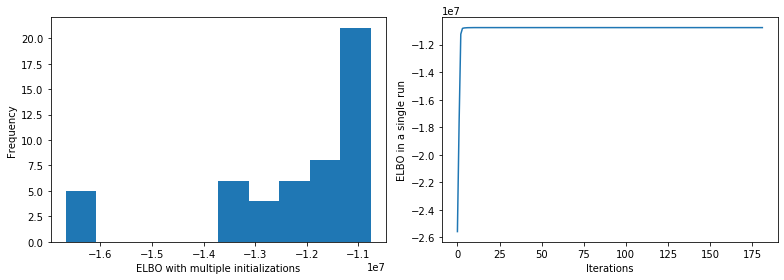

In [12]:
fig = plt.figure(figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.hist([x.ELBO_[-1] for x in _models_all])
plt.ylabel("Frequency")
plt.xlabel("ELBO with multiple initializations")

plt.subplot(1, 2, 2)
plt.plot(_losses)
plt.xlabel("Iterations")
plt.ylabel("ELBO in a single run")

plt.tight_layout()
plt.show()

In [13]:
print(modelCA.beta_mu),
print(modelCA.beta_sum)

[[0.44198 0.01237]
 [0.03038 0.49589]
 [0.01299 0.47904]
 [0.44901 0.01151]
 [0.92128 0.02880]
 [0.02946 0.92455]
 [0.48260 0.01087]
 [0.00142 0.24024]
 [0.45087 0.02793]
 [0.01175 0.01731]
 [0.02989 0.03679]
 [0.01447 0.01076]
 [0.02396 0.04830]
 [0.02815 0.01070]
 [0.10500 0.67217]
 [0.01284 0.01375]
 [0.01570 0.01688]
 [0.01483 0.01616]
 [0.01196 0.50000]
 [0.01915 0.02082]
 [0.01023 0.01109]
 [0.01839 0.01904]
 [0.01894 0.01908]
 [0.01118 0.01187]
 [0.01058 0.01133]
 [0.01189 0.01199]
 [0.03436 0.94893]
 [0.01746 0.01907]
 [0.02330 0.02501]
 [0.02565 0.02710]
 [0.00124 0.02966]
 [0.03520 0.04234]
 [0.00894 0.01183]
 [0.02292 0.03437]
 [0.01184 0.01765]
 [0.00922 0.01313]
 [0.00767 0.02634]
 [0.00658 0.01582]
 [0.01077 0.01814]
 [0.00746 0.01478]
 [0.01305 0.00825]
 [0.01273 0.45258]
 [0.48542 0.03124]
 [0.01863 0.01934]
 [0.01040 0.01102]
 [0.48419 0.02978]
 [0.01237 0.45485]
 [0.94351 0.03231]
 [0.03035 0.48632]
 [0.01234 0.01338]
 [0.01083 0.01169]
 [0.43641 0.43766]
 [0.92298 0.

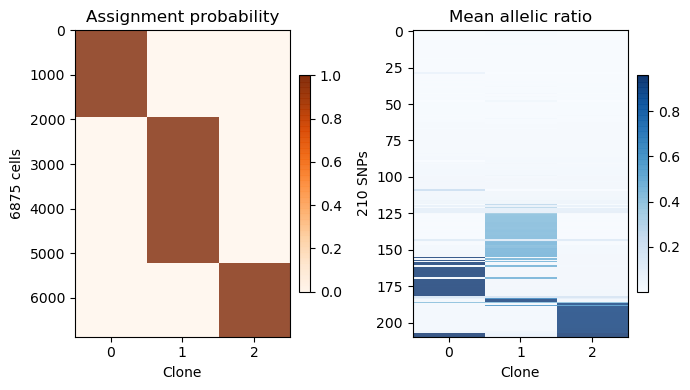

In [14]:
import matplotlib.pyplot as plt
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(7, 4), dpi=100)
plt.subplot(1, 2, 1)
im = heat_matrix(modelCA.ID_prob, cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Assignment probability")
plt.xlabel("Clone")
plt.ylabel("%d cells" %(modelCA.n_cell))
plt.xticks(range(modelCA.n_donor))


plt.subplot(1, 2, 2)
AF_SNPs = np.sum(modelCA.GT_prob * 
                 np.expand_dims(modelCA.beta_mu, 1), axis=2)
im = heat_matrix(AF_SNPs, cmap="Blues", alpha=0.8, 
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Mean allelic ratio")
plt.xlabel("Clone")
plt.ylabel("%d SNPs" %(modelCA.n_var))
plt.xticks(range(modelCA.n_donor))

plt.tight_layout()
plt.show()

In [15]:
np.sum(modelCA.predict_doublet(AD, DP)[0])

549.875544525905

### Choose the number of clones
We can choose the number of clones where ELBO stops increasing. Here, the best number of clone is 3.

Note, for a certain number of clone, e.g., n_clone=3, the ELBO may not the same for multiple initializations. This is becaused VI can only guarantee a local optima, so please choose the highest ELBO for each `n_clone` to represent its "global" optima.

In [16]:
n_initials = 50
n_clone_list = np.arange(2, 6)

_ELBO_mat = [] 
for k in n_clone_list:
    _elbo_temp = []
    for i in range(50):
        _modelCA = Vireo(n_var=AD_shape[0], n_cell=AD_shape[1], n_donor=k, n_GT=2,
                         fix_beta_sum=False, ASE_mode=True)
        _modelCA.set_prior(beta_mu_prior=np.array([[0.01, 0.5]]))
        _modelCA.fit(AD, DP, min_iter=20, verbose=False)
        _elbo_temp.append(_modelCA.ELBO_[-1])
    _ELBO_mat.append(_elbo_temp)

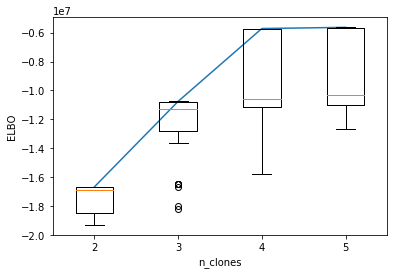

In [17]:
plt.plot([1, 2, 3, 4], np.max(_ELBO_mat, axis=1))
plt.boxplot(_ELBO_mat)
plt.xticks(n_clone_list - 1, n_clone_list)
plt.ylabel("ELBO")
plt.xlabel("n_clones")
plt.show()

### Old version

The old version seem more likely to end up at local optima in this data set.

In [18]:
from vireoSNP.utils.vireo_wrap_v02 import vireo_flock

In [19]:
# theta_prior = np.array([[0.01, 10], [0.4, 10], [5, 5]])
theta_prior = np.array([[0.1, 10], [5, 5]])
res = vireo_flock(AD, DP, n_donor=3, learn_GT=True,
                  n_extra_donor=0, ASE_mode=True,
                  theta_prior=theta_prior, learn_theta=True,
                  n_init=50, check_doublet=False, random_seed=1)

[vireo] warm-up: 50 random initializations for 3 clusters...
[vireo] donor size with searching extra 0 donors:
donor0	donor1	donor2
2319	2278	2278
[vireo] warm-up: lower bound ranges [-35769272.9, -35769272.9, -35767490.5]
[vireo] main RUN with warm initials and tuned GT ...
[vireo] main RUN: 37 iterations; lower bound -35767490.5
[vireo] beta parameters for binomial rate:
[[[0.10 0.10 0.10 0.10 0.10 0.10 0.10 3854.10 0.10 6508.10 16034.10
   5781.10 15665.10 8625.10 0.10 8264.10 9799.10 9136.10 6549.10
   10408.10 5593.10 10272.10 10158.10 6761.10 6203.10 6794.10 0.10
   10223.10 14534.10 16161.10 7267.10 26958.10 7747.10 19813.10 10671.10
   7694.10 11479.10 7342.10 9970.10 7213.10 6973.10 0.10 0.10 13593.10
   7156.10 0.10 0.10 0.10 0.10 7024.10 7214.10 0.10 0.10 0.10 0.10 0.10
   16394.10 0.10 16378.10 10870.10 11657.10 0.10 9774.10 5757.10 0.10
   6628.10 0.10 17897.10 23150.10 13002.10 17530.10 7483.10 18982.10
   13962.10 11706.10 0.10 4943.10 0.10 6487.10 0.10 0.10 0.10 5013.10

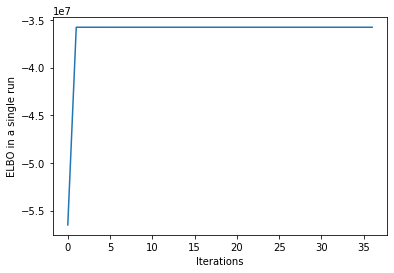

In [20]:
plt.plot(res['LB_list'])
plt.xlabel("Iterations")
plt.ylabel("ELBO in a single run")
plt.show()

In [21]:
## If ASE_mode is True
AF_mean = res['theta_shapes'][:, 0] / np.sum(res['theta_shapes'], axis=1)

_new_shape = (AF_mean.shape[1], 1, AF_mean.shape[0])
AF_SNPs = np.sum(res['GT_prob'] * AF_mean.transpose().reshape(_new_shape), axis=2)

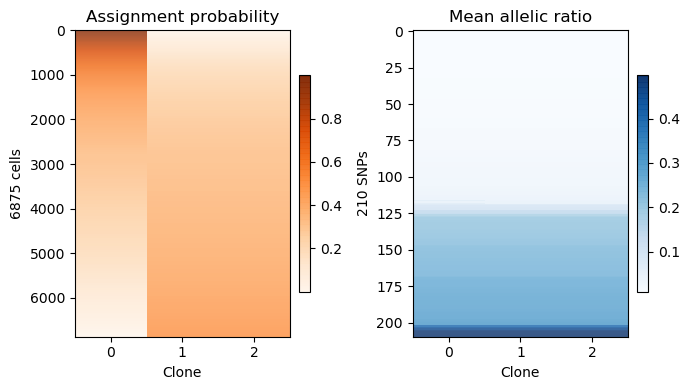

In [22]:
import matplotlib.pyplot as plt
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(7, 4), dpi=100)
plt.subplot(1, 2, 1)
im = heat_matrix(res['ID_prob'], cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Assignment probability")
plt.ylabel("%d cells" %(res['ID_prob'].shape[0]))
plt.xlabel("Clone")
plt.xticks([0, 1, 2])

plt.subplot(1, 2, 2)
im = heat_matrix(AF_SNPs, cmap="Blues", alpha=0.8, 
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Mean allelic ratio")
plt.xlabel("Clone")
plt.ylabel("%d SNPs" %(AF_SNPs.shape[0]))
plt.xticks([0, 1, 2])
plt.xlim(-0.5, 2.5)

plt.tight_layout()
plt.show()

## Plot K=4

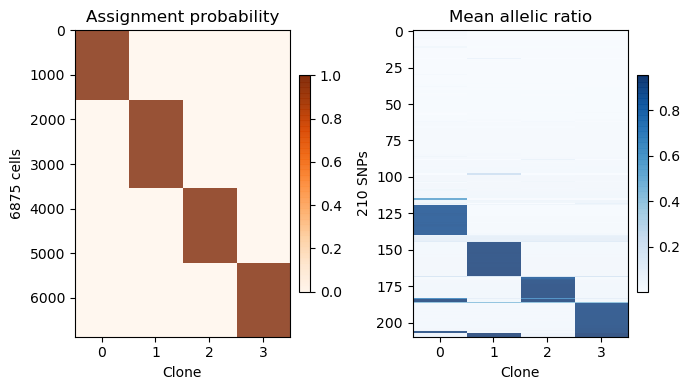

In [23]:
np.random.seed(1)

n_initials = 50
_models_all = []
for i in range(n_initials):
    _modelCA = Vireo(n_var=AD_shape[0], n_cell=AD_shape[1], n_donor=4, n_GT=2,
                     fix_beta_sum=False, ASE_mode=True)
    _modelCA.set_prior(beta_mu_prior=np.array([[0.01, 0.5]]))
    _modelCA.fit(AD, DP, min_iter=20, verbose=False, delay_fit_theta=0)
    _models_all.append(_modelCA)
    
## Choose the model giving highest ELBO

_idx = np.argmax([x.ELBO_[-1] for x in _models_all])
modelCA = _models_all[_idx]
_losses = modelCA.ELBO_


import matplotlib.pyplot as plt
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(7, 4), dpi=100)
plt.subplot(1, 2, 1)
im = heat_matrix(modelCA.ID_prob, cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Assignment probability")
plt.xlabel("Clone")
plt.ylabel("%d cells" %(modelCA.n_cell))
plt.xticks(range(modelCA.n_donor))


plt.subplot(1, 2, 2)
AF_SNPs = np.sum(modelCA.GT_prob * 
                 np.expand_dims(modelCA.beta_mu, 1), axis=2)
im = heat_matrix(AF_SNPs, cmap="Blues", alpha=0.8, 
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Mean allelic ratio")
plt.xlabel("Clone")
plt.ylabel("%d SNPs" %(modelCA.n_var))
plt.xticks(range(modelCA.n_donor))

plt.tight_layout()
plt.show()